# Loan Dataset - Lab

Original Dataset: 

## Dependencies

In [10]:
import re
from pathlib import Path

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Configure theme

In [12]:
plt.style.use('dark_background')

**Download** dataset from Kaggle

In [13]:
import kagglehub

# Download latest version
path = Path(kagglehub.dataset_download("ranadeep/credit-risk-dataset"))

path = path / "loan" / "loan.csv"

assert path.exists()
assert path.is_file()

print("Downloaded dataset to path:", path)

Downloaded dataset to path: /home/cube/.cache/kagglehub/datasets/ranadeep/credit-risk-dataset/versions/3/loan/loan.csv


Load dataset

In [14]:
df = pd.read_csv(path)
df = df.sample(n=50000, random_state=99)

/tmp/ipykernel_15760/1174564914.py:1: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


## Preprocessing

In [15]:
print(df.columns)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

Remove columns

In [16]:
df_dropped = [
    'id', 'member_id', 'emp_title', 'issue_d', 'pymnt_plan', 'url', 'desc', 'title', 'earliest_cr_line', 
    'mths_since_last_delinq', 'mths_since_last_record',
    'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 
    'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
    'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m'
]

df.drop(df_dropped, axis=1, inplace=True)

In [17]:
print(df.columns)

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'purpose',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')


Encode `loan_status`

In [18]:
loan_status_counts = df['loan_status'].value_counts()
print(loan_status_counts)

loan_status
Current                                                33850
Fully Paid                                             11794
Charged Off                                             2493
Late (31-120 days)                                       665
Issued                                                   466
In Grace Period                                          368
Late (16-30 days)                                        134
Does not meet the credit policy. Status:Fully Paid       114
Default                                                   71
Does not meet the credit policy. Status:Charged Off       45
Name: count, dtype: int64


In [19]:
df['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Does not meet the credit policy. Status:Charged Off',
       'Late (31-120 days)', 'Issued', 'Default', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid'], dtype=object)

In [20]:
# loan_target:
# 0: bad
# 1: good

df_loan_status_good = [
    'current',
    'fully paid',
    'issued',
]

def df_loan_status_map(x):
    if 'fully paid' in x.lower(): return 1
    return 1 if x.lower() in df_loan_status_good else 0

df['loan_target'] = df['loan_status'].map(df_loan_status_map).fillna(0)

In [21]:
df.drop('loan_status', axis=1, inplace=True)

Encode `emp_length`

In [22]:
df['emp_length'].unique()

array(['1 year', '10+ years', '2 years', '7 years', '9 years', '6 years',
       nan, '8 years', '3 years', '5 years', '< 1 year', '4 years'],
      dtype=object)

In [23]:
def df_emp_length_map(s):
    if s.lower() == '< 1 year':
        return 0
    
    m = re.search(r'\d+', s)
    return int(m.group()) if m else 0

df['emp_length'] = df['emp_length'].map(df_emp_length_map, na_action='ignore').fillna(0)

List **non numerical data**

In [24]:
df.select_dtypes(include=['object']).columns.tolist()

['term',
 'grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'zip_code',
 'addr_state']

Encode `term`

In [25]:
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [26]:
assert df['term'].isnull().sum() == 0

def df_term_map(s):
    if s.lower().strip() == '60 months':
        return 1
    return 0

df['term'] = df['term'].map(df_term_map)

Remove `grade` and encode `subgrade`

In [27]:
df.drop('grade', axis=1, inplace=True)

In [28]:
df['sub_grade'].unique()

array(['B3', 'A4', 'C2', 'C5', 'B5', 'D3', 'B4', 'C3', 'E1', 'E2', 'A2',
       'C4', 'E3', 'B2', 'D5', 'E4', 'A1', 'D1', 'C1', 'A5', 'A3', 'D2',
       'B1', 'D4', 'E5', 'F1', 'F3', 'F5', 'G4', 'F2', 'G3', 'F4', 'G1',
       'G2', 'G5'], dtype=object)

In [29]:
def df_sub_grade_map(s):
    return (ord(s[0]) - ord('A') + 1) + (int(s[1]) - 1) / 5

df['sub_grade'] = df['sub_grade'].map(df_sub_grade_map)

One hot encode `home_ownership`

In [30]:
df = pd.get_dummies(df, columns=['home_ownership'], drop_first=True)

One hot encode `verification_status`

In [31]:
df = pd.get_dummies(df, columns=['verification_status'], drop_first=True)

Target encode `purpose`

In [32]:
# Calculate the mean of the target variable for each category in the 'purpose' column
df_purpose_target_mean = df.groupby('purpose')['loan_target'].mean()

# Map these means back to the original dataframe
df['purpose'] = df['purpose'].map(df_purpose_target_mean)

Fill missing

In [33]:
def df_fill_missing_median_with_loan(c):
    median_good = df[df['loan_target'] == 1][c].median()
    median_bad = df[df['loan_target'] == 0][c].median()

    for index, row in df[df[c].isnull()].iterrows():
        if row['loan_target'] == 1:
            df.at[index, c] = median_good
        else:
            df.at[index, c] = median_bad


for c in [
    'revol_util', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'annual_inc', 
    'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 'acc_now_delinq'
]:
    df_fill_missing_median_with_loan(c)

Mark missing and delete

In [34]:
def df_mark(columns):
    for c in columns:
        df[f"{c}_m"] = df[c].apply(lambda x: 0 if pd.isna(x) else 1)

df_mark([])

Print columns with incomplete values

In [35]:
print(df.columns[df.isnull().any()].tolist())

[]


Ensure all cells are valid

In [36]:
assert df.isnull().sum().sum() == 0, "DataFrame contains NaN values"

## Analysis

Amount of good vs bad loans

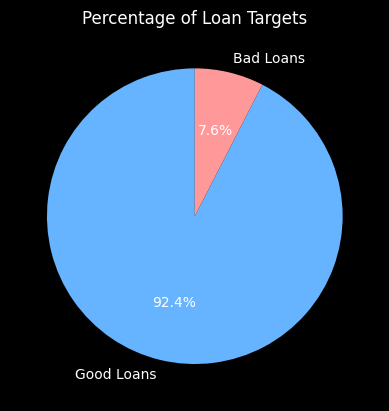

In [37]:
loan_target_counts = df['loan_target'].value_counts(normalize=True) * 100
loan_target_counts.plot(kind='pie', autopct='%1.1f%%', labels=['Good Loans', 'Bad Loans'], colors=['#66b3ff','#ff9999'], startangle=90)
plt.title('Percentage of Loan Targets')
plt.ylabel('')
plt.show()

### Lab Model

Split Data

In [39]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(['loan_target', 'zip_code', 'addr_state'], axis=1)
y = df['loan_target']

X.drop([
    'funded_amnt',
    'funded_amnt_inv',
    'out_prncp',
    'out_prncp_inv',
    'total_acc',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'total_rec_late_fee',
    'total_rec_prncp',
], axis=1, inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=99)

Create and train decision tree

In [40]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the random forest classifier
clf = RandomForestClassifier(random_state=99, n_estimators=300, max_depth=15)
clf.fit(X_train, y_train)

# Predict on the test data
clf_y_pred = clf.predict(X_test)

Create dummy classifier

In [41]:
from sklearn.dummy import DummyClassifier

# Create and train the dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=99)
dummy_clf.fit(X_train, y_train)

# Predict on the test data
dummy_y_pred = dummy_clf.predict(X_test)

### Classification Report

In [42]:
from sklearn.metrics import classification_report

In [43]:
# Generate the classification report
report = classification_report(y_test, clf_y_pred, target_names=['Bad Loans', 'Good Loans'])
print(report)

              precision    recall  f1-score   support

   Bad Loans       1.00      0.38      0.55       778
  Good Loans       0.95      1.00      0.97      9222

    accuracy                           0.95     10000
   macro avg       0.98      0.69      0.76     10000
weighted avg       0.95      0.95      0.94     10000



In [44]:
# Evaluate the dummy classifier
dummy_report = classification_report(y_test, dummy_y_pred, target_names=['Bad Loans', 'Good Loans'])
print(dummy_report)

              precision    recall  f1-score   support

   Bad Loans       0.00      0.00      0.00       778
  Good Loans       0.92      1.00      0.96      9222

    accuracy                           0.92     10000
   macro avg       0.46      0.50      0.48     10000
weighted avg       0.85      0.92      0.88     10000



/home/cube/source/dhbw/loan/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cube/source/dhbw/loan/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cube/source/dhbw/loan/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

List most important features

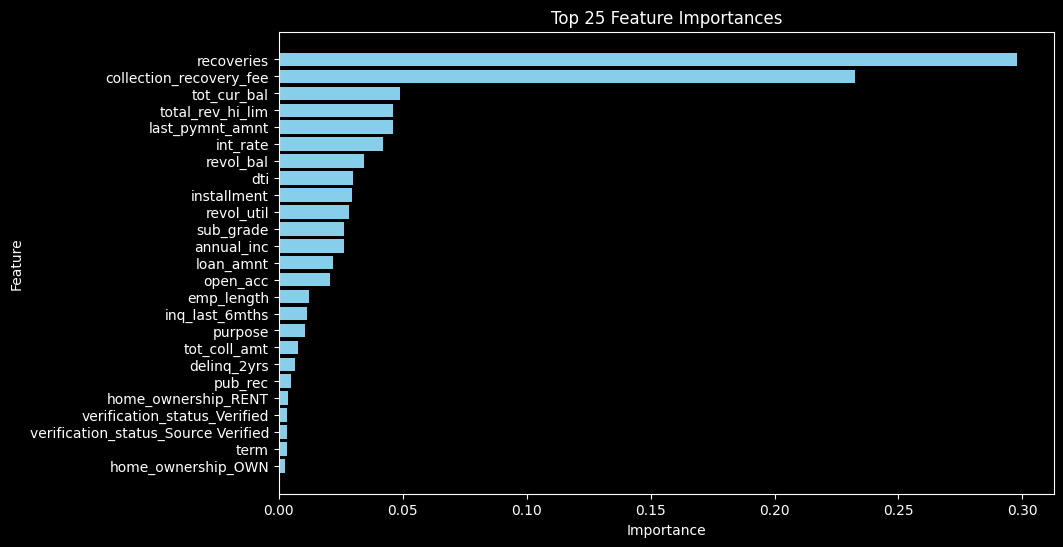

In [45]:
# Get feature importances
clf_importances = clf.feature_importances_
clf_feature_names = X.columns

# Create a DataFrame for visualization
clf_feature_importances = pd.DataFrame({'Feature': clf_feature_names, 'Importance': clf_importances})
clf_feature_importances = clf_feature_importances.sort_values(by='Importance', ascending=False).head(25)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(clf_feature_importances['Feature'], clf_feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 25 Feature Importances')
plt.gca().invert_yaxis()
plt.show()